In [ ]:
# importing a packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
warnings.filterwarnings('ignore')

In [ ]:
tataStockDF = pd.read_csv('/content/drive/MyDrive/Final_Year_Project/Harsh/TATASTEEL.NS.csv')
tataStockDF.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-05-31,106.400002,106.949997,105.599998,105.800003,102.456017,41249944
1,2023-06-01,105.900002,106.699997,105.800003,105.949997,102.601273,21211538
2,2023-06-02,106.500000,108.300003,106.500000,108.000000,104.586479,46686933
3,2023-06-05,108.650002,109.900002,107.800003,109.400002,105.942230,39642539
4,2023-06-06,109.750000,109.849998,108.300003,109.000000,105.554871,26751372


In [ ]:
tataStockDF.dtypes
tataStockDF.isnull().sum()
des_TATAStockDF = tataStockDF.describe()
des_TATAStockDF

,Open,High,Low,Close,Adj Close,Volume
count,246.000000,246.000000,246.000000,246.000000,246.000000,2.460000e+02
mean,134.343699,135.700000,132.656708,134.131097,133.903118,4.087840e+07
std,18.138535,18.478429,17.577731,17.982384,18.295330,2.077566e+07
min,105.900002,106.699997,105.599998,105.800003,102.456017,1.471945e+07
25%,119.762501,120.500000,118.437502,119.575003,119.575003,2.773584e+07
50%,130.324997,132.000000,128.750000,130.075005,130.075005,3.472816e+07
75%,143.937504,145.874996,142.149998,143.837494,143.837494,4.821713e+07
max,177.699997,177.699997,174.850006,175.500000,175.500000,1.669131e+08


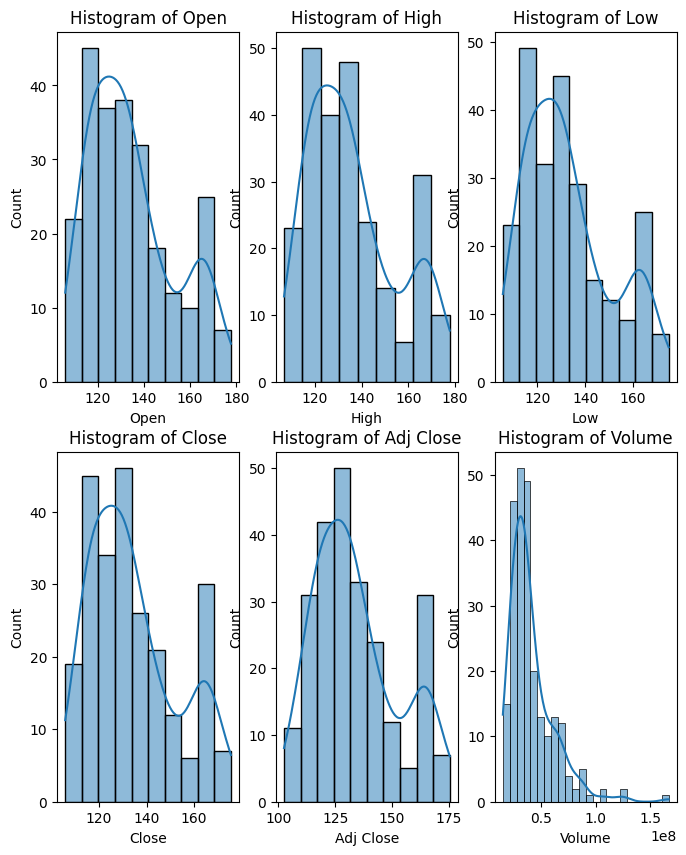

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8,10))

for i, (colm, ax) in enumerate(zip(des_TATAStockDF.columns, ax.flatten())):
  sns.histplot(data=tataStockDF, x=colm, ax=ax, kde=True)
  ax.set_title(f'Histogram of {colm}')

In [ ]:
tataStock_date = tataStockDF
tataStock_date.index = pd.to_datetime(tataStock_date['Date'])
tataStock_date.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2023-05-31,2023-05-31,106.400002,106.949997,105.599998,105.800003,102.456017,41249944
2023-06-01,2023-06-01,105.900002,106.699997,105.800003,105.949997,102.601273,21211538
2023-06-02,2023-06-02,106.500000,108.300003,106.500000,108.000000,104.586479,46686933
2023-06-05,2023-06-05,108.650002,109.900002,107.800003,109.400002,105.942230,39642539
2023-06-06,2023-06-06,109.750000,109.849998,108.300003,109.000000,105.554871,26751372


In [ ]:
tataStock_date['Month'] = tataStock_date.index.month
tataStock_date['Year']  = tataStock_date.index.year
tataStock_date['Week']  = tataStock_date.index.day_of_week
tataStock_date.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month,Year,Week
Date,,,,,,,,,,
2023-05-31,2023-05-31,106.400002,106.949997,105.599998,105.800003,102.456017,41249944,5,2023,2
2023-06-01,2023-06-01,105.900002,106.699997,105.800003,105.949997,102.601273,21211538,6,2023,3
2023-06-02,2023-06-02,106.500000,108.300003,106.500000,108.000000,104.586479,46686933,6,2023,4
2023-06-05,2023-06-05,108.650002,109.900002,107.800003,109.400002,105.942230,39642539,6,2023,0
2023-06-06,2023-06-06,109.750000,109.849998,108.300003,109.000000,105.554871,26751372,6,2023,1


In [ ]:
#Adding Lagged Features for prediction
tataStock_date['Lag1'] = tataStock_date['Close'].shift(1)
tataStock_date['Lag2'] = tataStock_date['Close'].shift(2)
tataStock_date['Lag3'] = tataStock_date['Close'].shift(3)
# Dataset after the adding Lagged Feature with NaN value
tataStock_date.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month,Year,Week,Lag1,Lag2,Lag3
Date,,,,,,,,,,,,,
2023-05-31,2023-05-31,106.400002,106.949997,105.599998,105.800003,102.456017,41249944,5,2023,2,NaN,NaN,NaN
2023-06-01,2023-06-01,105.900002,106.699997,105.800003,105.949997,102.601273,21211538,6,2023,3,105.800003,NaN,NaN
2023-06-02,2023-06-02,106.500000,108.300003,106.500000,108.000000,104.586479,46686933,6,2023,4,105.949997,105.800003,NaN
2023-06-05,2023-06-05,108.650002,109.900002,107.800003,109.400002,105.942230,39642539,6,2023,0,108.000000,105.949997,105.800003
2023-06-06,2023-06-06,109.750000,109.849998,108.300003,109.000000,105.554871,26751372,6,2023,1,109.400002,108.000000,105.949997


In [ ]:
# Dropping NaN value
tataStock_date.dropna(inplace=True)
tataStock_date.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month,Year,Week,Lag1,Lag2,Lag3
Date,,,,,,,,,,,,,
2023-06-05,2023-06-05,108.650002,109.900002,107.800003,109.400002,105.942230,39642539,6,2023,0,108.000000,105.949997,105.800003
2023-06-06,2023-06-06,109.750000,109.849998,108.300003,109.000000,105.554871,26751372,6,2023,1,109.400002,108.000000,105.949997
2023-06-07,2023-06-07,109.500000,111.750000,108.900002,111.500000,107.975853,45157197,6,2023,2,109.000000,109.400002,108.000000
2023-06-08,2023-06-08,111.500000,113.000000,110.949997,111.150002,107.636917,46380294,6,2023,3,111.500000,109.000000,109.400002
2023-06-09,2023-06-09,111.250000,111.650002,108.650002,108.900002,105.458038,36392617,6,2023,4,111.150002,111.500000,109.000000


In [ ]:
x = tataStock_date[['Month', 'Year', 'Week', 'Lag1', 'Lag2', 'Lag3']]
y = tataStock_date[['Close']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
print('X_train shape :' ,x_train.shape)
print('X_test  shape :' ,x_test.shape)
print('Y_train shape :' ,y_train.shape)
print('Y_test  shape :' ,y_test.shape)

X_train shape : (194, 6)
X_test  shape : (49, 6)
Y_train shape : (194, 1)
Y_test  shape : (49, 1)


Epoch 1/50
13/13 [==============================] - 1s 17ms/step - loss: 22043.1680 - val_loss: 5525.6851
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 17015.9238 - val_loss: 808.2527
Epoch 3/50
13/13 [==============================] - 0s 6ms/step - loss: 11513.6504 - val_loss: 1174.7903
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 8999.4121 - val_loss: 427.7560
Epoch 5/50
13/13 [==============================] - 0s 6ms/step - loss: 6972.9736 - val_loss: 553.4590
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 5753.6558 - val_loss: 755.9424
Epoch 7/50
13/13 [==============================] - 0s 6ms/step - loss: 6132.0864 - val_loss: 581.8618
Epoch 8/50
13/13 [==============================] - 0s 6ms/step - loss: 4413.5571 - val_loss: 903.8210
Epoch 9/50
13/13 [==============================] - 0s 9ms/step - loss: 4017.9595 - val_loss: 645.3874
Epoch 10/50
13/13 [==============================] - 0s 8ms/step - 

2/2 [==============================] - 0s 7ms/step
Mean Squared Error: 891.6827944808806


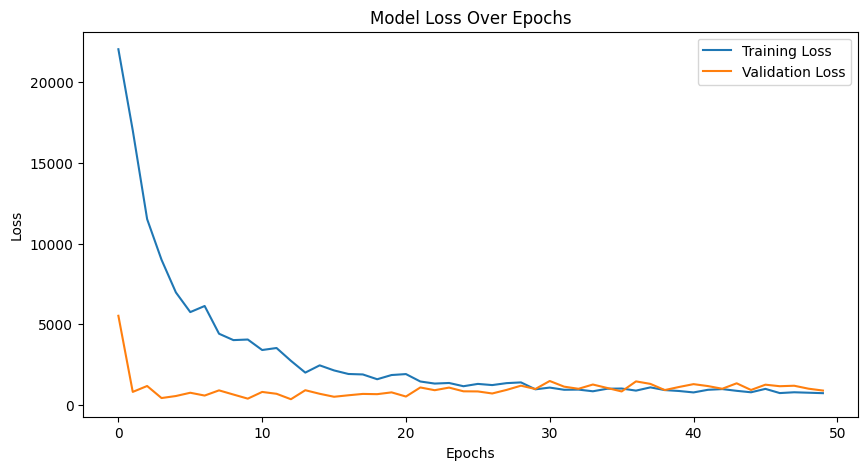

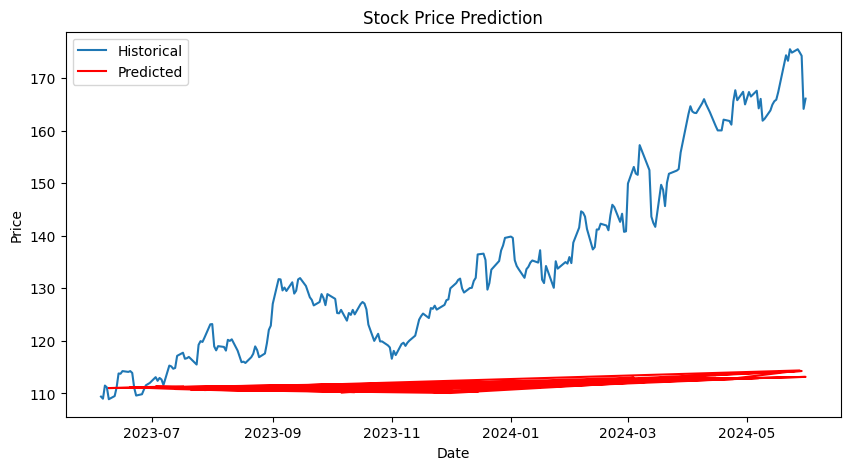

In [ ]:
# Define Neural Network Model
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_test, y_test))

# Prediction
predictions = model.predict(x_test)

# Evaluation
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(tataStock_date.index, tataStock_date['Close'], label='Historical')
plt.plot(y_test.index, predictions, label='Predicted', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()